# Object Detection

## Traing [YOLO-V5](https://github.com/ultralytics/yolov5) on [Fruits Dataset](https://www.kaggle.com/kanmeh/fruits-dataset?select=train_zip).

<p><br>

<div>
<img src="./Sourses/1.png" width="400" height="200"/>
</div>

<p><br>


**YOLOv5** is a family of object detection architectures and models pretrained on the COCO dataset, and represents [**Ultralytics**](https://docs.ultralytics.com/) open-source research into future vision AI methods, incorporating lessons learned and best practices evolved over thousands of hours of research and development.



## Connent to google drive


In [1]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Step-1: Read and Refine Data to yolo format




## UnZip Data

In [3]:
# !unzip '/content/drive/MyDrive/Fruits/test_zip.zip' 
# !unzip '/content/drive/MyDrive/Fruits/train_zip.zip' 

##Conver to yolo format

In [86]:

import glob
from numpy import expand_dims
from keras.models import load_model
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
import glob
import os
import pickle
import xml.etree.ElementTree as ET
from os import listdir, getcwd
from os.path import join
import cv2
import matplotlib.pyplot as plt
import glob
from shutil import copy

def getImagesInDir(dir_path):
    image_list = []
    for filename in glob.glob(dir_path + '/*.jpg'):
        image_list.append(filename)

    return image_list

def convert(size, box):
    dw = 1./(size[0])
    dh = 1./(size[1])
    x = (box[0] + box[1])/2.0 - 1
    y = (box[2] + box[3])/2.0 - 1
    w = box[1] - box[0]
    h = box[3] - box[2]
    x = x*dw
    w = w*dw
    y = y*dh
    h = h*dh
    return (x,y,w,h)

def convert_annotation(dir_path, output_path_label,output_path_image, image_path):
    img = {'object':[]}
    img['filename'] = image_path
    basename = os.path.basename(image_path)
    copy(image_path,output_path_image) 
    basename_no_ext = os.path.splitext(basename)[0]

    in_file = open(dir_path + '/' + basename_no_ext + '.xml')
    out_file = open(output_path_label + basename_no_ext + '.txt', 'w')
    tree = ET.parse(in_file)
    root = tree.getroot()
    size = root.find('size')
    w = int(size.find('width').text)
    img['width'] = w
    h = int(size.find('height').text)
    img['height'] = h
    objs = {}
    flag=False
    for obj in root.iter('object'):    
        difficult = obj.find('difficult').text
        cls = obj.find('name').text

        if cls not in classes or int(difficult)==1:
            continue
        objs['name'] = cls
        cls_id = classes.index(cls)
        xmlbox = obj.find('bndbox')
        xmin,xmax,ymin,ymax = float(xmlbox.find('xmin').text), float(xmlbox.find('xmax').text), float(xmlbox.find('ymin').text), float(xmlbox.find('ymax').text)
        b = (xmin,xmax,ymin,ymax)
        objs['xmin'],objs['xmax'],objs['ymin'],objs['ymax'] = xmin,xmax,ymin,ymax
        if w==0 or h==0:
            flag=False
        else:
            bb = convert((w,h), b)
            img['object'] += [objs]
            out_file.write(str(cls_id) + " " + " ".join([str(a) for a in bb]) + '\n')
            flag=True

    return img,flag



classes = ['apple','banana','orange']  

dirs = ['train','test']
train_image_folder = "/content/train"
test_image_folder = "/content/test"


   
def process_annotation(name):
    all_imgs  =  []
    full_dir_path='/content/'+name+'/'
    output_path_label= '/content/Fruits/labels/'+name+'/'
    output_path_image= '/content/Fruits/images/'+name

    if not os.path.exists(output_path_label):
        os.makedirs(output_path_label)
    if not os.path.exists(output_path_image):
        os.makedirs(output_path_image)

    image_paths = getImagesInDir(full_dir_path)
    list_file = open('/content/Fruits/' + name+'.txt', 'w')

    for image_path in image_paths:
        
        img,flag=convert_annotation(full_dir_path, output_path_label,output_path_image, image_path)
        if flag == False:
            continue
        else:
            list_file.write(image_path + '\n')
            all_imgs += [img]
    list_file.close()

    print("Finished processing: " + full_dir_path)
    return all_imgs

all_imgs_train = process_annotation('train')
all_imgs_test = process_annotation('test')  

Finished processing: /content/train/
Finished processing: /content/test/


In [87]:
all_imgs_train[0]

{'filename': '/content/train/banana_36.jpg',
 'height': 387,
 'object': [{'name': 'banana',
   'xmax': 497.0,
   'xmin': 74.0,
   'ymax': 387.0,
   'ymin': 58.0}],
 'width': 620}

In [88]:
len(all_imgs_train)

207

## Remove extra files

In [78]:
# to remove a whole of a directory
os.system("rm -rf /content/yolov5/")
# os.system("rm -rf /content/test/")

0

In [5]:
!ls

drive  Fruits  sample_data  test  train  yolov3  yolov5


#  Step-2: Obtain Best Anchor boxes (clustring on IOU and save to yolovv5.yaml)

The k-mean clustering has two simple steps:

Set the number of clusters and initialize the cluster centers


1.  allocate each item to the closest cluster centers(the distance to the cluster center is calculated using 1 - IOU),
2.  calculate the cluster centers as mean (or median) of all the cases in the clusters(used median to calculate the cluster centers),

Repeat steps 1 and 2 until the two consective iterations yield the same cluster centers.

In [12]:
import numpy as np
def kmeans(boxes, k, dist=np.median,seed=1):
    """
    Calculates k-means clustering with the Intersection over Union (IoU) metric.
    :param boxes: numpy array of shape (r, 2), where r is the number of rows
    :param k: number of clusters
    :param dist: distance function
    :return: numpy array of shape (k, 2)
    """
    rows = boxes.shape[0]

    distances     = np.empty((rows, k)) ## N row x N cluster
    last_clusters = np.zeros((rows,))

    np.random.seed(seed)

    # initialize the cluster centers to be k items
    clusters = boxes[np.random.choice(rows, k, replace=False)]

    while True:
        # Step 1: allocate each item to the closest cluster centers
        for icluster in range(k): # I made change to lars76's code here to make the code faster
            distances[:,icluster] = 1 - iou(clusters[icluster], boxes)

        nearest_clusters = np.argmin(distances, axis=1)

        if (last_clusters == nearest_clusters).all():
            break
            
        # Step 2: calculate the cluster centers as mean (or median) of all the cases in the clusters.
        for cluster in range(k):
            clusters[cluster] = dist(boxes[nearest_clusters == cluster], axis=0)

        last_clusters = nearest_clusters

    return clusters,nearest_clusters,distances

def iou(box, clusters):
    '''
    :param box:      np.array of shape (2,) containing w and h
    :param clusters: np.array of shape (N cluster, 2) 
    '''
    x = np.minimum(clusters[:, 0], box[0]) 
    y = np.minimum(clusters[:, 1], box[1])

    intersection = x * y
    box_area = box[0] * box[1]
    cluster_area = clusters[:, 0] * clusters[:, 1]

    iou_ = intersection / (box_area + cluster_area - intersection)

    return iou_

## Extract width and height of the images 

In [45]:
wh = []
for anno in all_imgs_train:
    ow = float(anno['width'])  # width of the original image
    oh = float(anno['height']) # height of the original image
    for obj in anno["object"]:
        w = (obj["xmax"] - obj["xmin"])*(640/ow)    #*(640/ow) is to scale bbox in the range of 640 * 640
        h = (obj["ymax"] - obj["ymin"])*(640/oh)
        wh.append([w,h])
wh = np.array(wh)
print("clustering feature data is ready. shape = (N object, width and height) =  {}".format(wh.shape))

clustering feature data is ready. shape = (N object, width and height) =  (420, 2)


## To find out 9 clusters

In [46]:
N_clusters = 9
dist = np.mean
results = {}
for k in range(2,N_clusters+1):
    clusters, nearest_clusters, distances = kmeans(wh,k,seed=2,dist=dist)
    WithinClusterMeanDist = np.mean(distances[np.arange(distances.shape[0]),nearest_clusters])
    result = {"clusters":             clusters,
              "nearest_clusters":     nearest_clusters,
              "distances":            distances,
              "WithinClusterMeanDist": WithinClusterMeanDist}
    print("{:2.0f} clusters: mean IoU = {:5.4f} ".format(k,1-result["WithinClusterMeanDist"]))
    results[k] = result

anchors=results[N_clusters]['clusters']
anchors=sorted(anchors, key=lambda x: x[0])   # 0 sort based on width , 1 sort based on height
anchors=np.round(anchors)
print("Obtained anchors : \n",anchors)

 2 clusters: mean IoU = 0.6408 
 3 clusters: mean IoU = 0.6697 
 4 clusters: mean IoU = 0.7195 
 5 clusters: mean IoU = 0.7401 
 6 clusters: mean IoU = 0.7524 
 7 clusters: mean IoU = 0.7768 
 8 clusters: mean IoU = 0.7854 
 9 clusters: mean IoU = 0.7897 
Obtained anchors : 
 [[        117         237]
 [        188         195]
 [        221         307]
 [        289         447]
 [        296         214]
 [        380         315]
 [        461         402]
 [        465         201]
 [        480         527]]


## Obtain 3 anchors for each of the three scales

In [47]:
anchors = anchors.reshape(3,6)
print("Final anchors for the three scales: \n",anchors)

Final anchors for the three scales: 
 [[        117         237         188         195         221         307]
 [        289         447         296         214         380         315]
 [        461         402         465         201         480         527]]


In [48]:
!ls

CONTRIBUTING.md  export.py   __pycache__       test.py	       yolov5s.pt
data		 hubconf.py  README.md	       train.py
detect.py	 LICENSE     requirements.txt  tutorial.ipynb
Dockerfile	 models      runs	       utils


In [49]:
import yaml
with open("/content/drive/MyDrive/Fruits/Fruits.yaml", 'r') as ymlfile:
    cfg = yaml.load(ymlfile)
print(cfg)    

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  This is separate from the ipykernel package so we can avoid doing imports until


{'path': '../Fruits/images', 'train': '../Fruits/images/train', 'val': '../Fruits/images/train', 'test': '../Fruits/images/test', 'nc': 3, 'names': ['apple', 'banana', 'orange']}


# Step-3: Run YOLO_V5

In [4]:
import torch
from IPython.display import Image  # for displaying images

print('torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))


torch 1.9.0+cu102 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15109MB, multi_processor_count=40


## Clone the repository

In [2]:
!git clone https://github.com/ultralytics/yolov5  # clone repo

Cloning into 'yolov5'...
remote: Enumerating objects: 8102, done.
remote: Counting objects: 100% (414/414), done.
remote: Compressing objects: 100% (173/173), done.
remote: Total 8102 (delta 286), reused 347 (delta 241), pack-reused 7688
Receiving objects: 100% (8102/8102), 9.40 MiB | 27.34 MiB/s, done.
Resolving deltas: 100% (5584/5584), done.


## Install requirments

In [97]:
!pip install -U -r yolov5/requirements.txt  # install dependencies

     |████████████████████████████████| 10.3MB 5.1MB/s 
     |████████████████████████████████| 15.7MB 197kB/s 
     |████████████████████████████████| 49.9MB 130kB/s 
     |████████████████████████████████| 3.0MB 38.5MB/s 
     |████████████████████████████████| 645kB 44.7MB/s 
     |████████████████████████████████| 28.5MB 117kB/s 
Requirement already up-to-date: torch>=1.7.0 in /usr/local/lib/python3.7/dist-packages (from -r yolov5/requirements.txt (line 10)) (1.9.0+cu102)
Requirement already up-to-date: torchvision>=0.8.1 in /usr/local/lib/python3.7/dist-packages (from -r yolov5/requirements.txt (line 11)) (0.10.0+cu102)
     |████████████████████████████████| 81kB 10.3MB/s 
Requirement already up-to-date: tensorboard>=2.4.1 in /usr/local/lib/python3.7/dist-packages (from -r yolov5/requirements.txt (line 15)) (2.5.0)
Requirement already up-to-date: seaborn>=0.11.0 in /usr/local/lib/python3.7/dist-packages (from -r yolov5/requirements.txt (line 19)) (0.11.1)
     |██████████████████

In [7]:
cd /content/yolov5

/content/yolov5


In [8]:
!ls

CONTRIBUTING.md  Dockerfile  LICENSE	requirements.txt  tutorial.ipynb
data		 export.py   models	test.py		  utils
detect.py	 hubconf.py  README.md	train.py


## Training

In [9]:
! python train.py --img 640 --batch 32 --epochs 100 --data /content/drive/MyDrive/Fruits/Fruits-yolov5.yaml --cfg /content/drive/MyDrive/Fruits/yolov5s.yaml --weights yolov5s.pt 


train: weights=yolov5s.pt, cfg=/content/drive/MyDrive/Fruits/yolov5s.yaml, data=/content/drive/MyDrive/Fruits/Fruits-yolov5.yaml, hyp=data/hyps/hyp.scratch.yaml, epochs=100, batch_size=32, img_size=[640], rect=False, resume=False, nosave=False, notest=False, noautoanchor=False, evolve=None, bucket=, cache_images=False, image_weights=False, device=, multi_scale=False, single_cls=False, adam=False, sync_bn=False, workers=8, project=runs/train, entity=None, name=exp, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, upload_dataset=False, bbox_interval=-1, save_period=-1, artifact_alias=latest, local_rank=-1
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v5.0-288-g8ee9fd1 torch 1.9.0+cu102 CUDA:0 (Tesla P4, 7611.9375MB)

hyperparameters: lr0=0.01, lrf=0.2, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0

## Test using the new weights 
available in runs/train/exp/weights/

In [10]:
!python test.py --data /content/drive/MyDrive/Fruits/Fruits-yolov5.yaml --weights /content/yolov5/runs/train/exp/weights/best.pt --img 640 --conf-thres 0.1

test: data=/content/drive/MyDrive/Fruits/Fruits-yolov5.yaml, weights=['/content/yolov5/runs/train/exp/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.1, iou_thres=0.6, task=val, device=, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/test, name=exp, exist_ok=False, half=False
YOLOv5 🚀 v5.0-288-g8ee9fd1 torch 1.9.0+cu102 CUDA:0 (Tesla P4, 7611.9375MB)

Fusing layers... 
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
Model Summary: 224 layers, 7059304 parameters, 0 gradients, 16.3 GFLOPs
val: Scanning '../Fruits/labels/train.cache' images and lab

##Show results of test batches

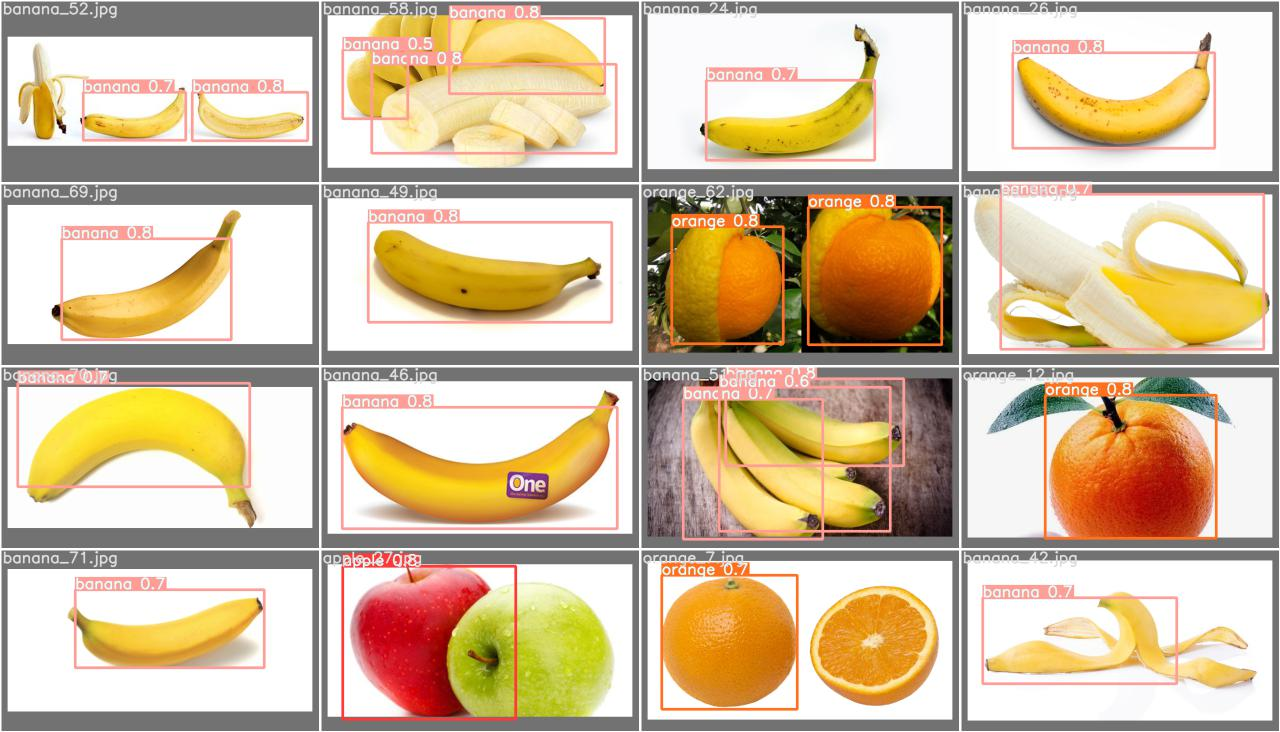

In [16]:
from IPython.display import Image
Image(filename='/content/yolov5/runs/test/exp/test_batch0_pred.jpg') 
# Image(filename='/content/yolov5/runs/test/exp/test_batch0_labels.jpg') 


## Detect results on one test image e.g. mixed_21.jpg

In [20]:
!python detect.py --weights /content/yolov5/runs/train/exp/weights/best.pt --img 640 --conf 0.1 --source /content/Fruits/images/test/mixed_21.jpg


detect: weights=['/content/yolov5/runs/train/exp/weights/best.pt'], source=/content/Fruits/images/test/mixed_21.jpg, imgsz=640, conf_thres=0.1, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False
YOLOv5 🚀 v5.0-288-g8ee9fd1 torch 1.9.0+cu102 CUDA:0 (Tesla P4, 7611.9375MB)

Fusing layers... 
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
Model Summary: 224 layers, 7059304 parameters,

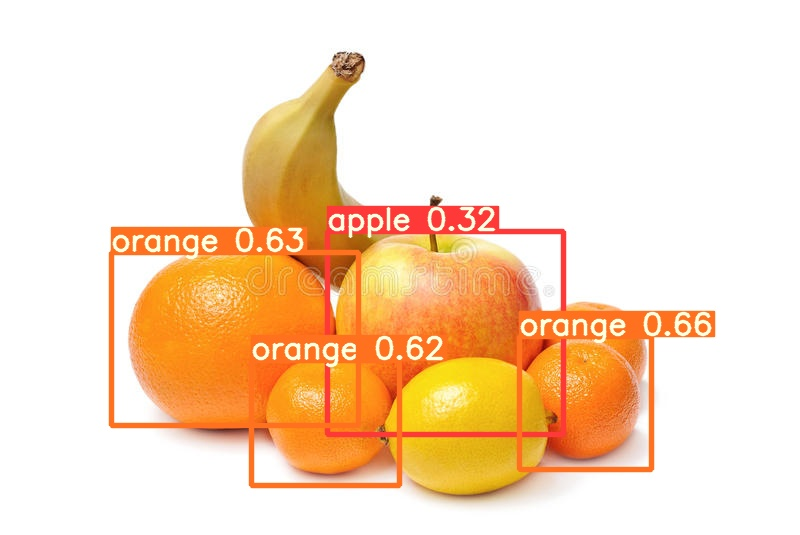

In [24]:
from IPython.display import Image
Image(filename='/content/yolov5/runs/detect/exp3/mixed_21.jpg') 

## Plot results


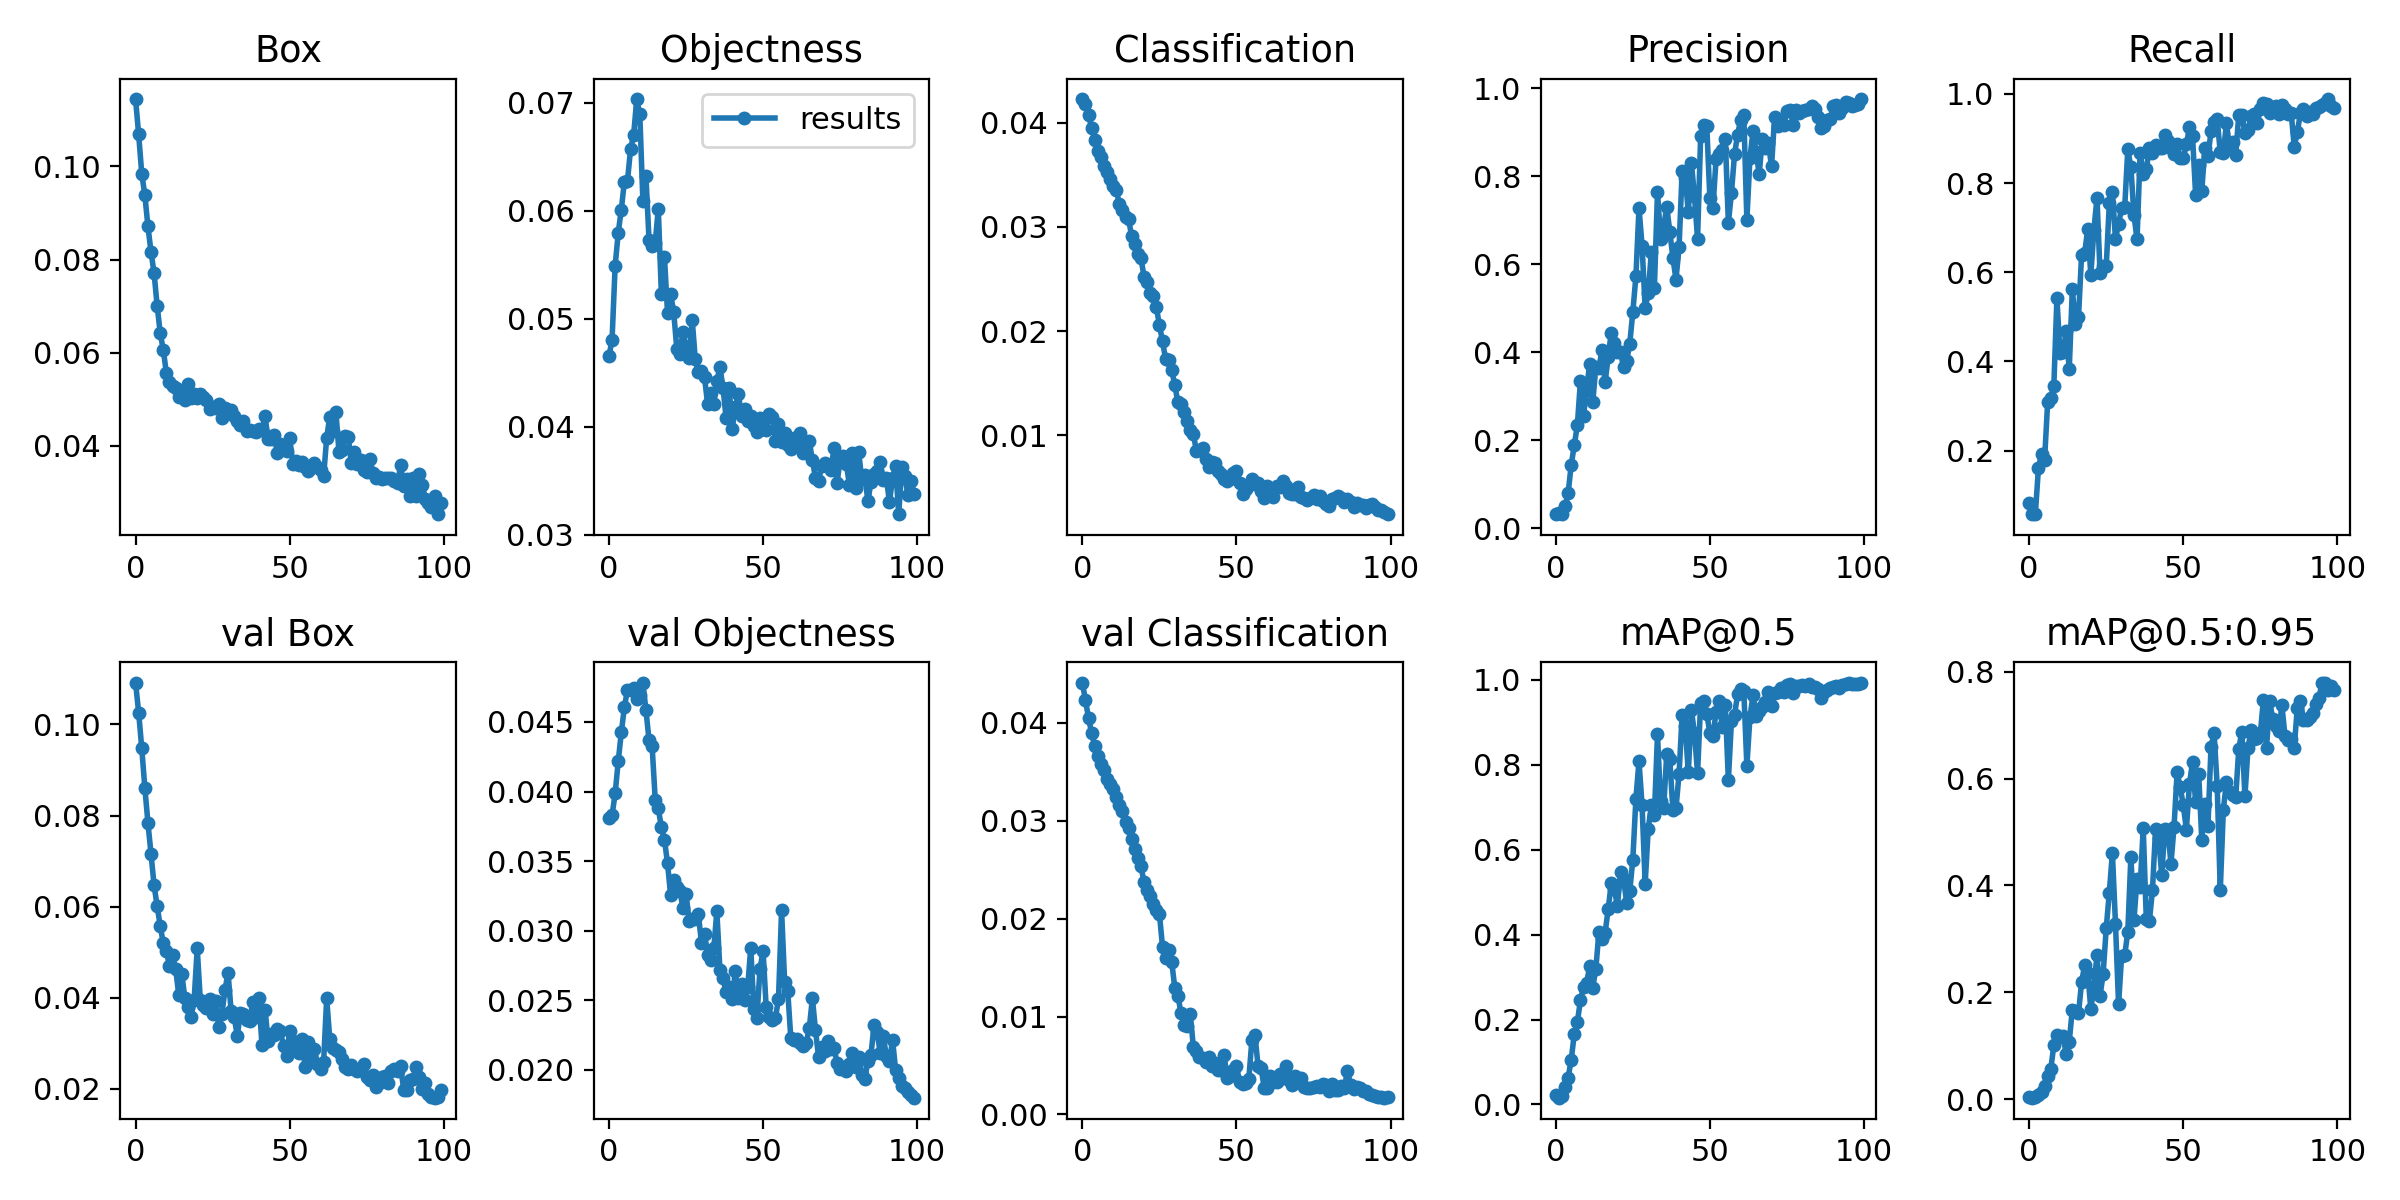

In [25]:
from utils.plots import plot_results 
plot_results(save_dir='runs/train/exp')  # plot all results*.txt files in 'runs/train/exp'
Image(filename='runs/train/exp/results.png', width=800)

## Download results to local system

In [5]:
# !zip -r /content/runs.zip /content/yolov5/runs

In [6]:
# from google.colab import files
# files.download("/content/yolov5/runs")